# Calculate anomalies

## Calculates climate anomalies based on a rolling window average 

- 

## Setup

<xarray.Dataset> Size: 77MB
Dimensions:      (time: 228, lat: 71, lon: 74)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lat          (lat) float32 284B -9.825 -9.875 -9.925 ... -13.28 -13.33
  * lon          (lon) float32 296B -72.38 -72.32 -72.28 ... -68.78 -68.72
    spatial_ref  int64 8B ...
Data variables:
    tmmx         (time, lat, lon) float64 10MB ...
    tmmn         (time, lat, lon) float64 10MB ...
    pr           (time, lat, lon) float64 10MB ...
    pdsi         (time, lat, lon) float64 10MB ...
    def          (time, lat, lon) float64 10MB ...
    vpd          (time, lat, lon) float64 10MB ...
    soil         (time, lat, lon) float64 10MB ...
    lai          (time, lat, lon) float64 10MB ...
EPSG:4326
('time', 'lat', 'lon')


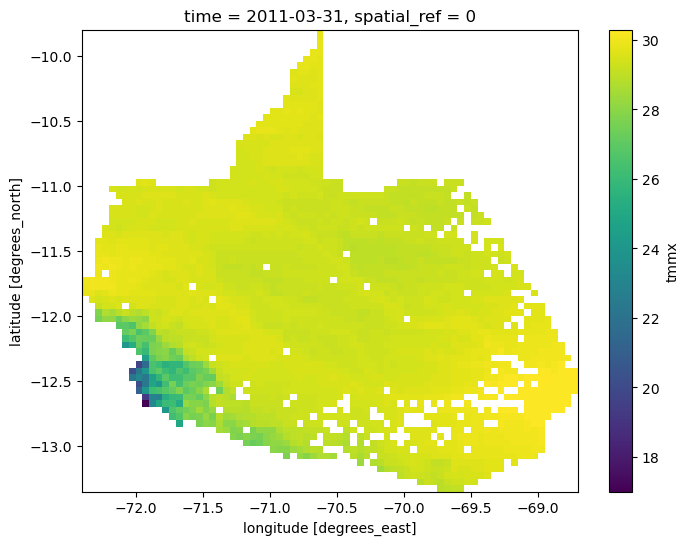

In [7]:
# import packages
import xarray as xr
import rioxarray as rio
import numpy as np
import geopandas as gpd
import pandas as pd
import os
import glob
import rasterio
import re
import matplotlib
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from rasterio.enums import Resampling 

# load in data
# --------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------

# climate + LAI netCDF
# --------------------------

# load data set
combo_xr = xr.open_dataset("/home/jovyan/large_files/climLai_masked_v3.nc")

# set a crs (somehow it loses this when you export as a netCDF)
if combo_xr.rio.crs is None:
    combo_xr = combo_xr.rio.write_crs("EPSG:4326")

# print some info
print(combo_xr)
print(combo_xr['lai'].rio.crs)
print(combo_xr['lai'].dims)
# print(combo_xr.time.values)

# plot
combo_xr.tmmx.isel(time=110).plot(figsize=(8,6))


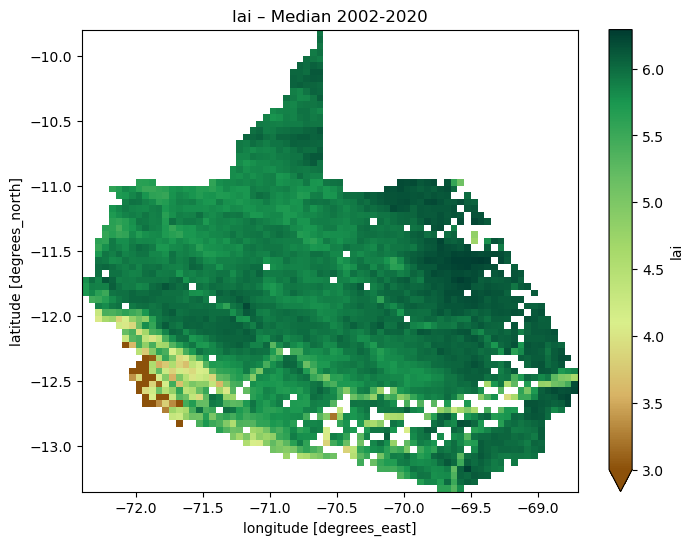

In [62]:
# Pick the band
var_name = list(combo_xr.data_vars)[7]

# Median over time
median_map = combo_xr[var_name].median(dim="time")

# Your colors → continuous gradient
# my_colors = [
#     "#08306b",  # darker blue (new)
#     "#2c7bb6",  # blue
#     "#abd9e9",  # light blue
#     "#ffffbf",  # yellow
#     "#fdae61",  # orange
#     "#d7191c",  # red
#     "#67000d"   # darker red (new)
# ]

my_colors = [
    "#8c510a",  # dark brown (very low LAI / bare)
    "#d8b365",  # light brown
    "#d9ef8b",  # yellow-green (replaced pale yellow)
    "#a6d96a",  # light green (replaced very light green)
    "#66bd63",  # medium green
    "#1a9850",  # dark green
    "#003c30"   # very dark green (dense canopy)
]

custom_cmap = LinearSegmentedColormap.from_list("custom_continuous", my_colors)

# Plot
plt.figure(figsize=(8,6))
median_map.plot(cmap=custom_cmap,#.reversed(),
               vmin=3, #0, #-2, #0,     
               #  vmax=6.5 #10 #2 #35
               )      
plt.title(f"{var_name} – Median 2002-2020")
plt.show()

## Visualize

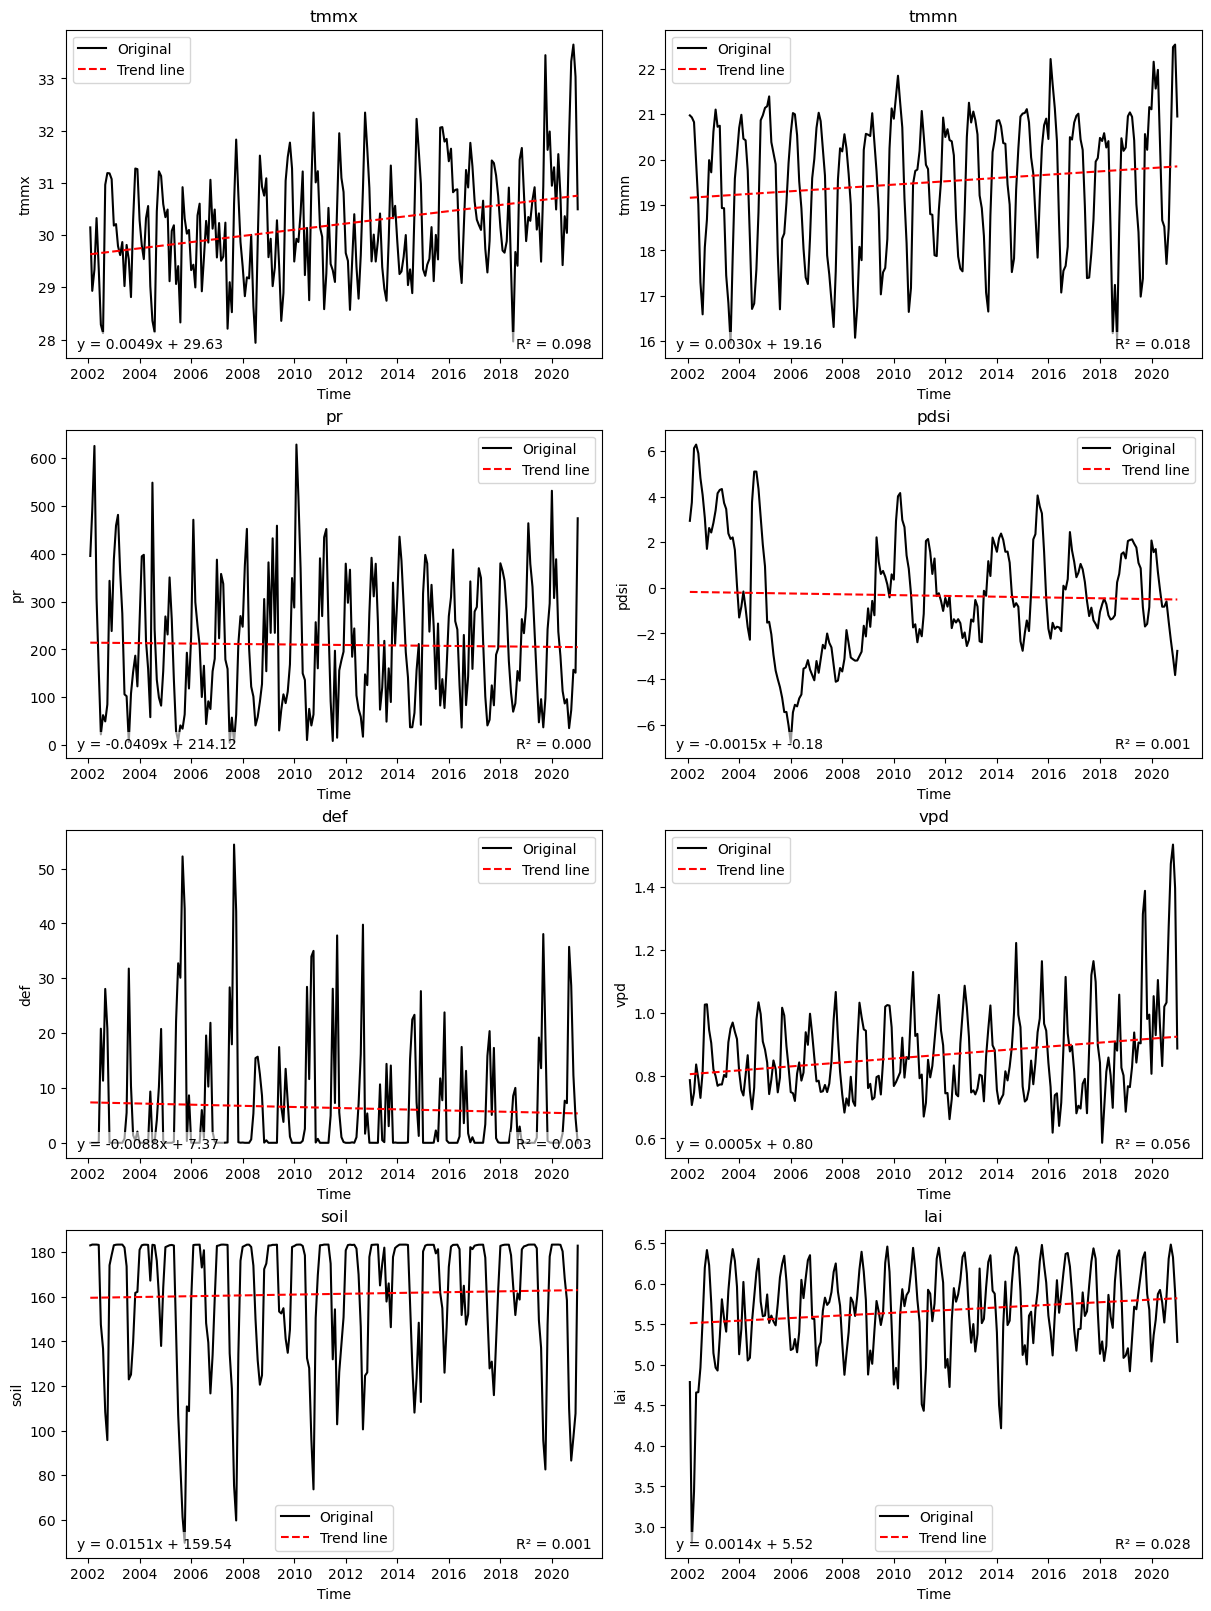

In [2]:
# Take spatial mean so we get 1D time series
spatialMean_xr = combo_xr.mean(dim=["lat", "lon"])

num_vars = len(spatialMean_xr.data_vars)
ncols = 2  # adjust number of columns for tiling
nrows = int(np.ceil(num_vars / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows*4), constrained_layout=True)
axes = axes.flatten()  # flatten in case of more than 1 row/col

for i, var in enumerate(spatialMean_xr.data_vars):
    y = spatialMean_xr[var].values
    x = np.arange(len(y))  # simple index for time axis

    # Fit linear trend
    coeffs = np.polyfit(x, y, 1)
    trend = np.polyval(coeffs, x)

    # Calculate R^2
    correlation_matrix = np.corrcoef(y, trend)
    r_squared = correlation_matrix[0, 1]**2

    # Plot
    axes[i].plot(spatialMean_xr.time.values, y, color="black", label="Original")
    axes[i].plot(spatialMean_xr.time.values, trend, color="red", linestyle="--", label="Trend line")

    # Add equation box (lower left)
    eq_text = f"y = {coeffs[0]:.4f}x + {coeffs[1]:.2f}"
    axes[i].text(0.02, 0.02, eq_text, transform=axes[i].transAxes,
                 fontsize=10, verticalalignment='bottom', horizontalalignment='left',
                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    # Add R² box (lower right)
    r2_text = f"R² = {r_squared:.3f}"
    axes[i].text(0.98, 0.02, r2_text, transform=axes[i].transAxes,
                 fontsize=10, verticalalignment='bottom', horizontalalignment='right',
                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    axes[i].set_title(var)
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel(var)
    axes[i].legend()

# Remove empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Save as one PNG
plt.savefig("/home/jovyan/MLEAEEE4000-DroughtAmazon2/figures/varRaw_timeSeriesFull_wTrend.png", dpi=300, bbox_inches='tight')
plt.show()

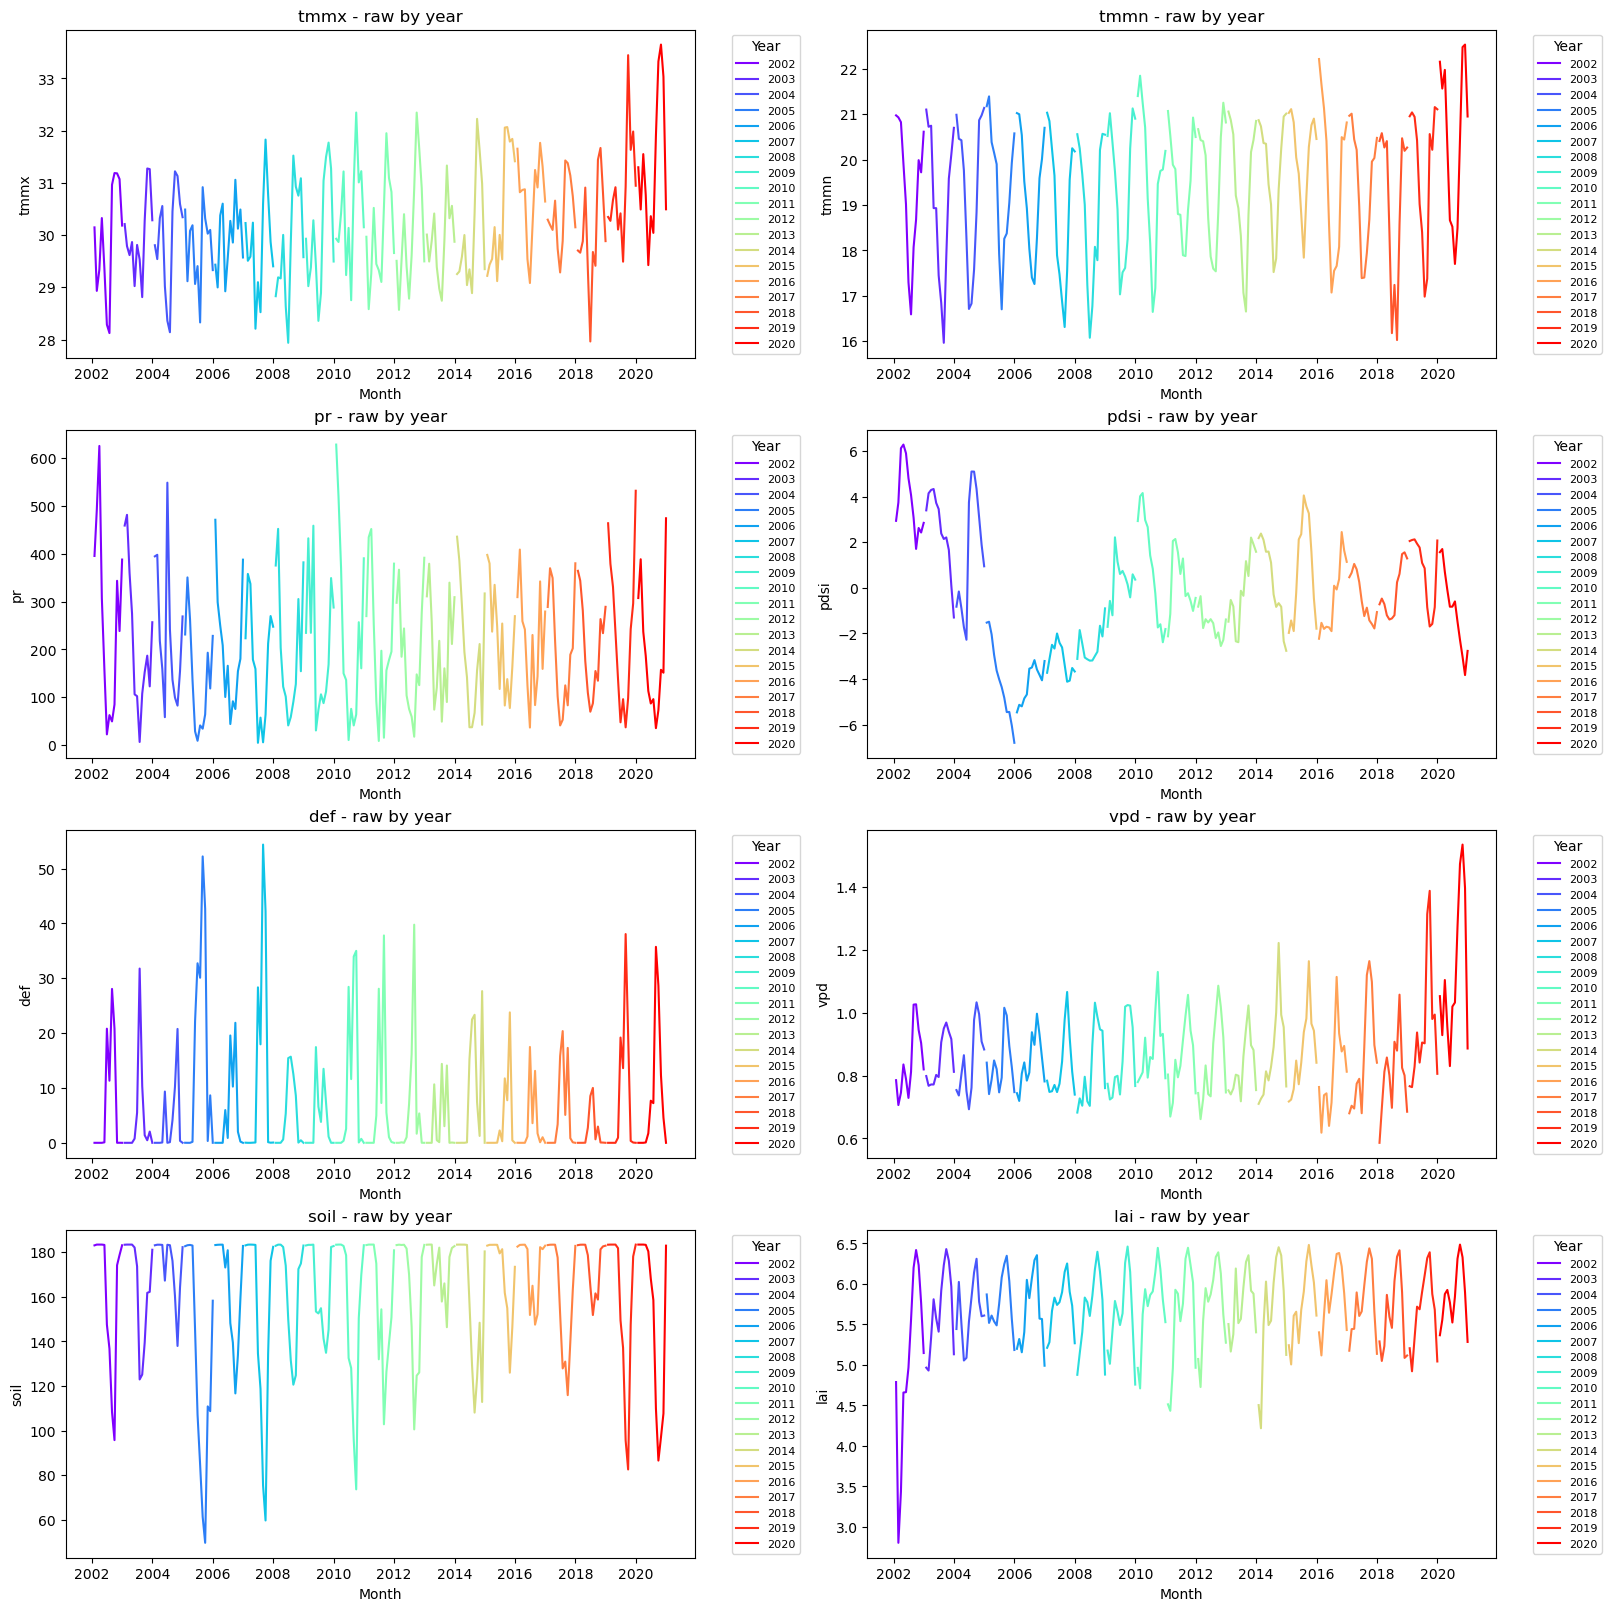

In [3]:
# Compute spatial mean
spatialMean_xr = combo_xr.mean(dim=["lat", "lon"])

# Assign 'year' and 'month' as coordinates (for plotting convenience)
spatialMean_xr = spatialMean_xr.assign_coords(
    year=spatialMean_xr.time.dt.year,
    month=spatialMean_xr.time.dt.month
)

# Determine grid size
num_vars = len(spatialMean_xr.data_vars)
ncols = 2
nrows = int(np.ceil(num_vars / ncols))

# Create a figure with subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(16, nrows * 4), constrained_layout=True)
axes = axes.flatten()  # flatten in case nrows*ncols > num_vars

for idx, var in enumerate(spatialMean_xr.data_vars):
    ax = axes[idx]
    
    years = sorted(list(set(spatialMean_xr[var].time.dt.year.values)))
    colors = cm.rainbow(np.linspace(0, 1, len(years)))  # rainbow palette
    
    for i, (year, group) in enumerate(spatialMean_xr[var].groupby("year")):
        group.plot(ax=ax, label=str(year), color=colors[i])
    
    ax.set_title(f"{var} - raw by year")
    ax.set_xlabel("Month")
    ax.set_ylabel(var)
    
    # Place legend outside the plot
    ax.legend(title="Year", fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')

# Remove empty subplots if any
for j in range(idx+1, nrows*ncols):
    fig.delaxes(axes[j])

# Save as one image
plt.savefig("/home/jovyan/MLEAEEE4000-DroughtAmazon2/figures/varRaw_timeSeriesFull.png", dpi=300, bbox_inches='tight')
plt.show()

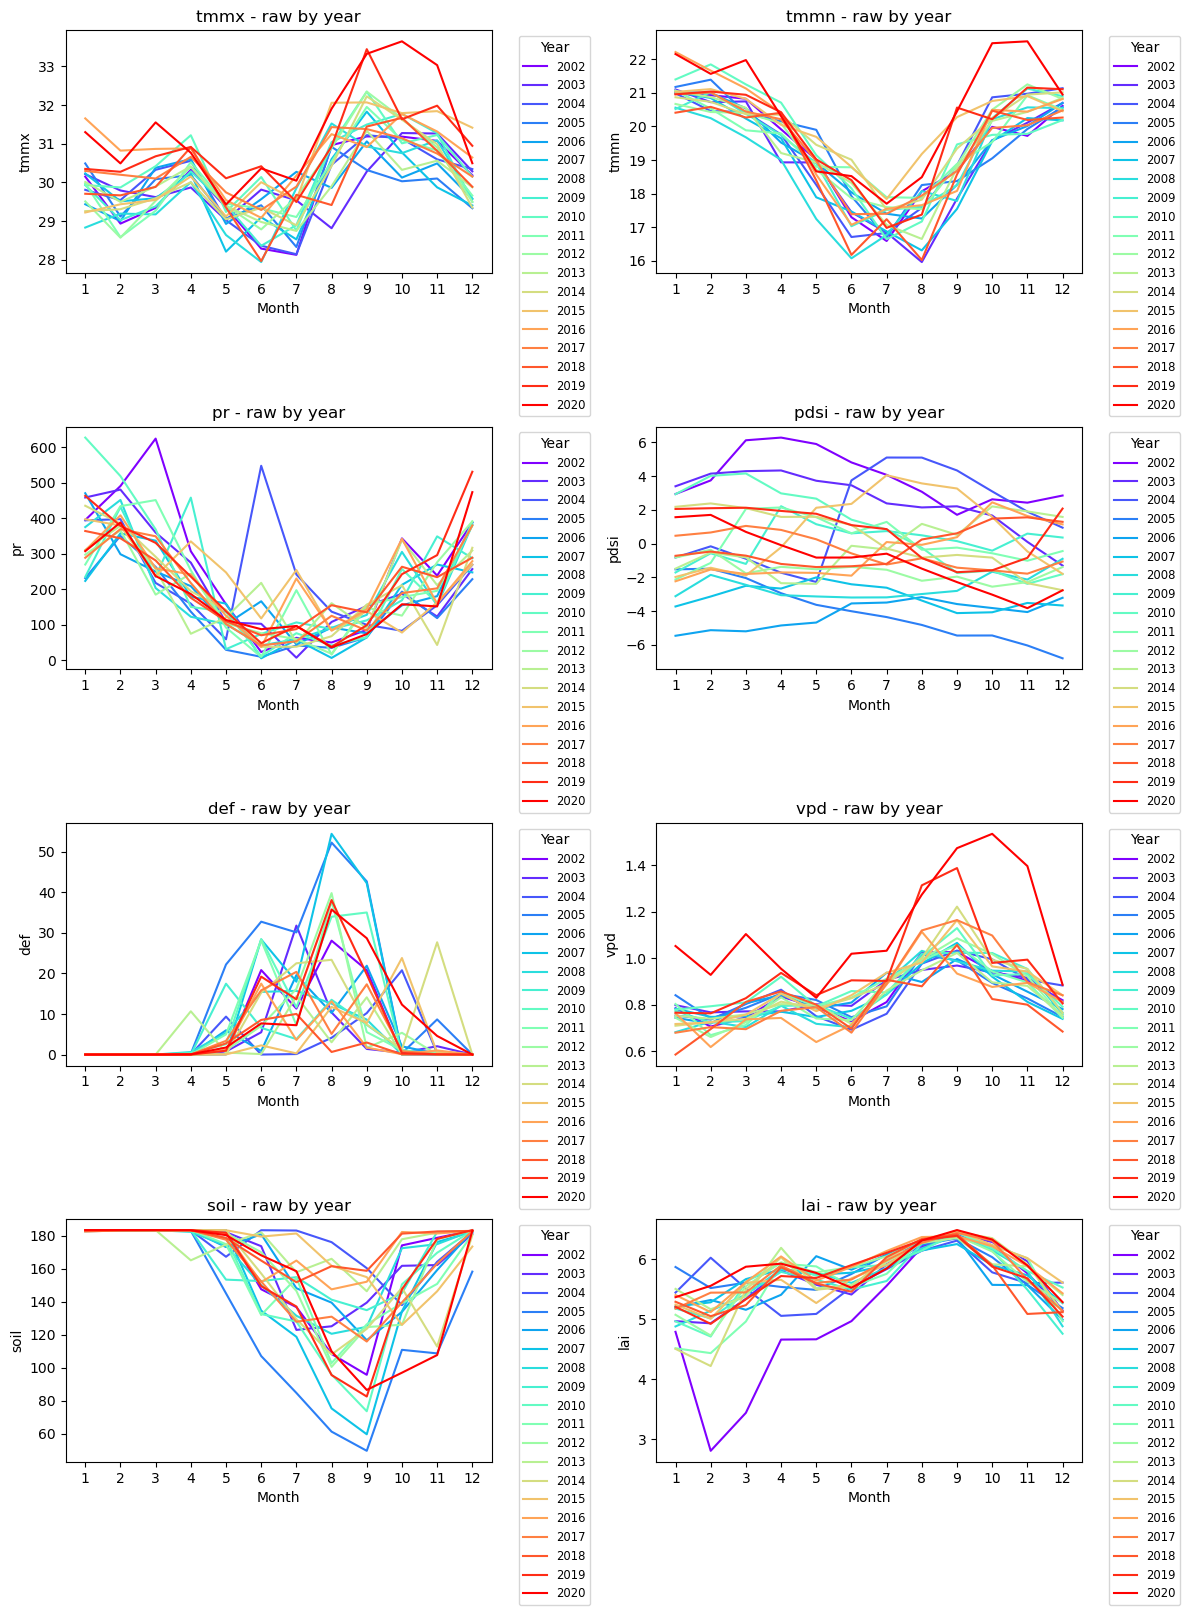

In [88]:
spatialMean_xr = combo_xr.mean(dim=["lat", "lon"])

# Assign 'year' and 'month' as coordinates (for plotting convenience)
spatialMean_xr = spatialMean_xr.assign_coords(
    year=spatialMean_xr.time.dt.year,
    month=spatialMean_xr.time.dt.month
)

# Determine grid size
num_vars = len(spatialMean_xr.data_vars)
ncols = 2  # number of columns in grid
nrows = int(np.ceil(num_vars / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows*4))
axes = axes.flatten()  # flatten in case of single row/column

# Loop over variables
for ax, var in zip(axes, spatialMean_xr.data_vars):
    for i, (year, group) in enumerate(spatialMean_xr[var].groupby("year")):
        monthly = group.groupby("month").mean("time")
        ax.plot(monthly.month, monthly, color=cmap(i), label=str(year))
    
    ax.set_xlabel("Month")
    ax.set_ylabel(var)
    ax.set_title(f"{var} - raw by year")
    ax.set_xticks(range(1,13))
    ax.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Remove empty axes if any
for j in range(len(spatialMean_xr.data_vars), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("/home/jovyan/MLEAEEE4000-DroughtAmazon2/figures/varRaw_monthOverlay.png", dpi=300, bbox_inches='tight')
plt.show()

# Calculate Anomalies

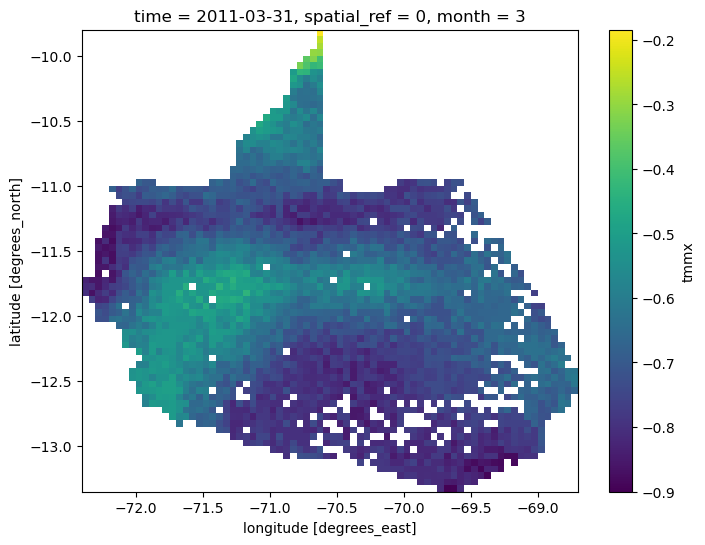

In [54]:
# Calculate monthly climatology for the whole dataset
monthlyMean_xr = combo_xr.groupby("time.month").mean("time")

# Subtract climatology to get seasonal anomalies
combo_deseason_xr = combo_xr.groupby("time.month") - monthlyMean_xr

# plot
combo_deseason_xr.tmmx.isel(time=110).plot(figsize=(8,6))

## Export

In [89]:
# Export to a netCDF (optional)
output_path = "/home/jovyan/large_files/climLai_masked_anom.nc"
combo_deseason_xr.to_netcdf(output_path)

# Visualize

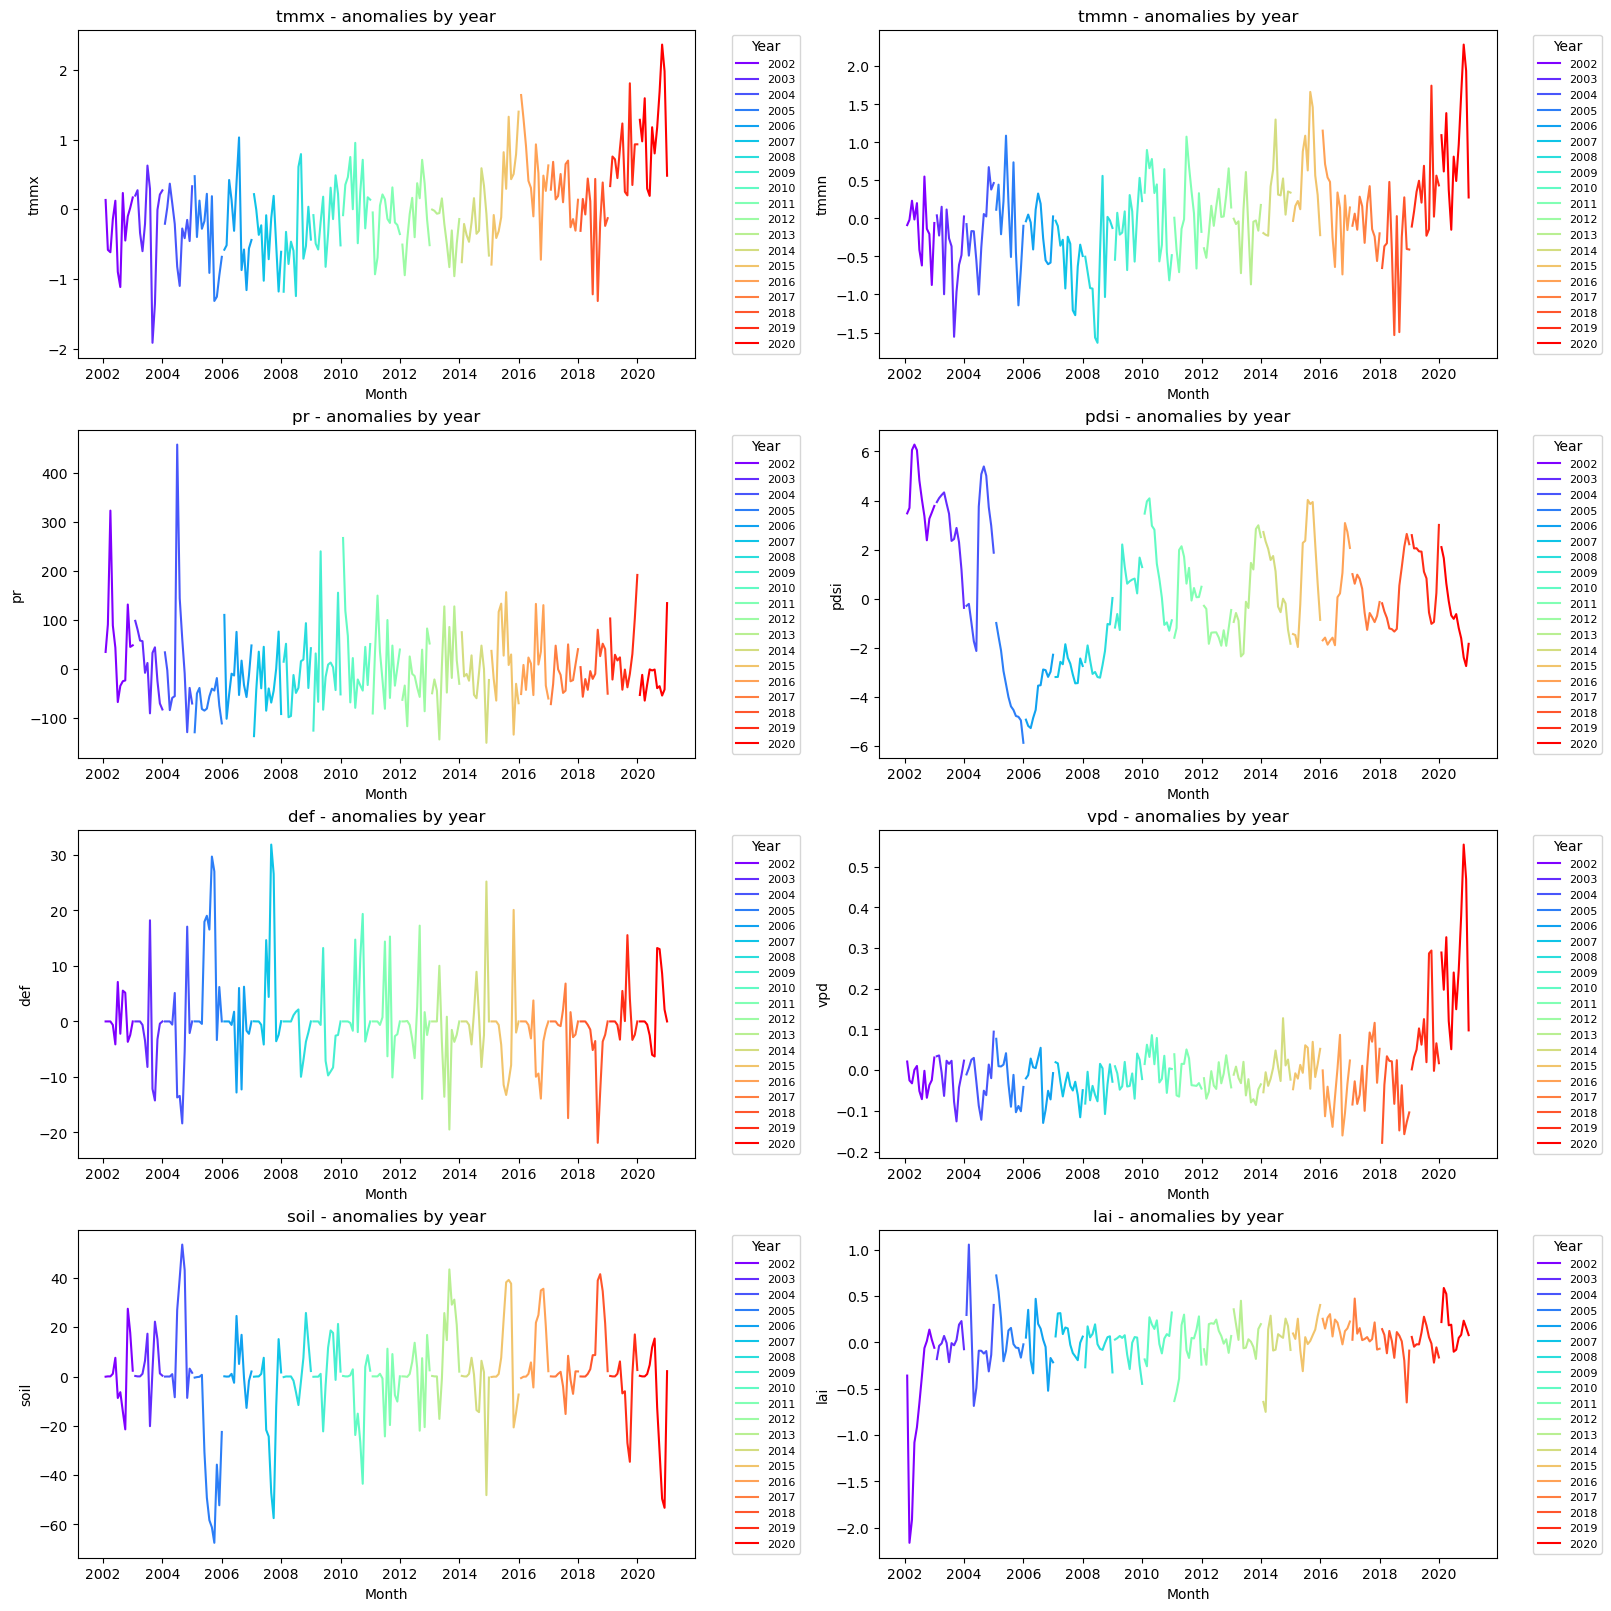

In [85]:
# Compute spatial mean
spatialMean_xr = combo_deseason_xr.mean(dim=["lat", "lon"])

# Assign 'year' and 'month' as coordinates (for plotting convenience)
spatialMean_xr = spatialMean_xr.assign_coords(
    year=spatialMean_xr.time.dt.year,
    month=spatialMean_xr.time.dt.month
)

# Determine grid size
num_vars = len(spatialMean_xr.data_vars)
ncols = 2
nrows = int(np.ceil(num_vars / ncols))

# Create a figure with subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(16, nrows * 4), constrained_layout=True)
axes = axes.flatten()  # flatten in case nrows*ncols > num_vars

for idx, var in enumerate(spatialMean_xr.data_vars):
    ax = axes[idx]
    
    years = sorted(list(set(spatialMean_xr[var].time.dt.year.values)))
    colors = cm.rainbow(np.linspace(0, 1, len(years)))  # rainbow palette
    
    for i, (year, group) in enumerate(spatialMean_xr[var].groupby("year")):
        group.plot(ax=ax, label=str(year), color=colors[i])
    
    ax.set_title(f"{var} - anomalies by year")
    ax.set_xlabel("Month")
    ax.set_ylabel(var)
    
    # Place legend outside the plot
    ax.legend(title="Year", fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')

# Remove empty subplots if any
for j in range(idx+1, nrows*ncols):
    fig.delaxes(axes[j])

# Save as one image
plt.savefig("/home/jovyan/MLEAEEE4000-DroughtAmazon2/figures/varAnom_timeSeriesFull.png", dpi=300, bbox_inches='tight')
plt.show()

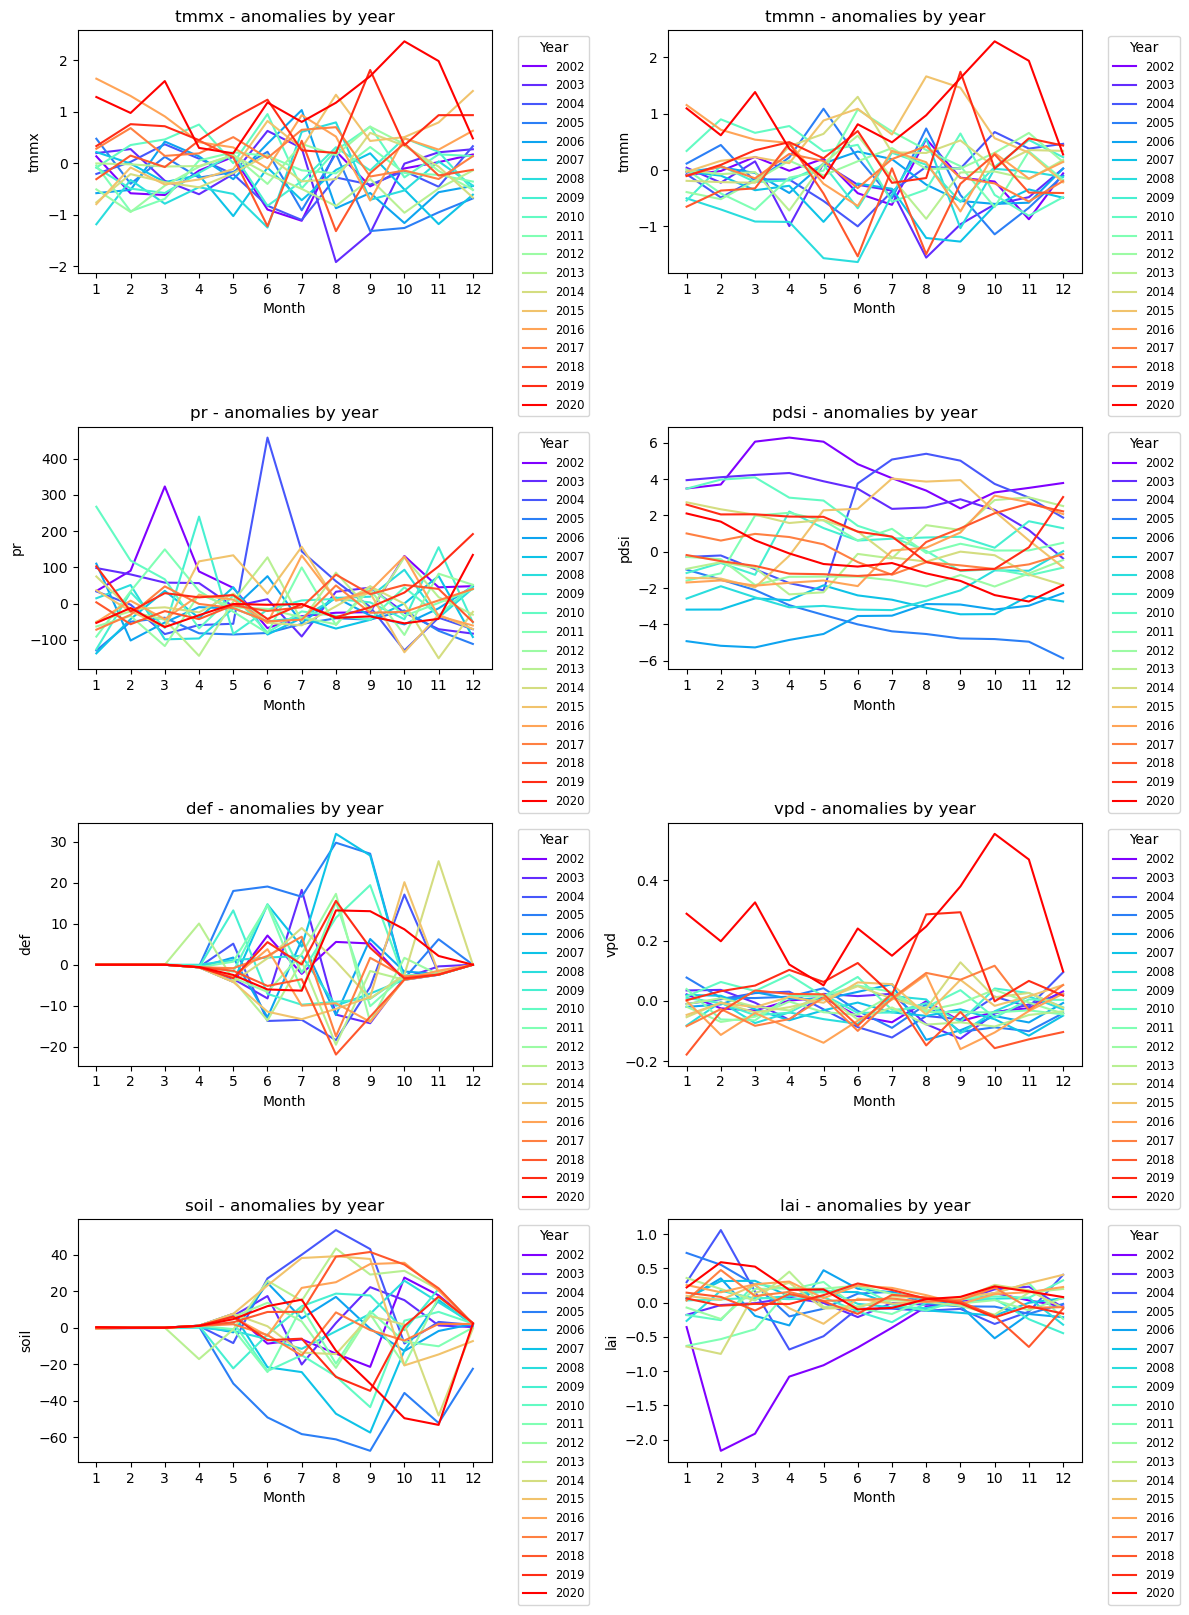

In [87]:
spatialMean_xr = combo_deseason_xr.mean(dim=["lat", "lon"])

# Assign 'year' and 'month' as coordinates (for plotting convenience)
spatialMean_xr = spatialMean_xr.assign_coords(
    year=spatialMean_xr.time.dt.year,
    month=spatialMean_xr.time.dt.month
)

# Determine grid size
num_vars = len(spatialMean_xr.data_vars)
ncols = 2  # number of columns in grid
nrows = int(np.ceil(num_vars / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows*4))
axes = axes.flatten()  # flatten in case of single row/column

# Loop over variables
for ax, var in zip(axes, spatialMean_xr.data_vars):
    for i, (year, group) in enumerate(spatialMean_xr[var].groupby("year")):
        monthly = group.groupby("month").mean("time")
        ax.plot(monthly.month, monthly, color=cmap(i), label=str(year))
    
    ax.set_xlabel("Month")
    ax.set_ylabel(var)
    ax.set_title(f"{var} - anomalies by year")
    ax.set_xticks(range(1,13))
    ax.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Remove empty axes if any
for j in range(len(spatialMean_xr.data_vars), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("/home/jovyan/MLEAEEE4000-DroughtAmazon2/figures/varAnom_monthOverlay.png", dpi=300, bbox_inches='tight')
plt.show()